In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

***Multiple Gas Phase Reactions in a PBR***

You can download Fogler's book from here:
https://doku.pub/download/h-scott-fogler-essentials-of-chemical-reaction-engineering-z0x2ze484wqn

***Multiple Gas Phase Reactions in a PBR***

\begin{equation*}A + 2B → C \tag{1}\end{equation*}

\begin{equation*}2A + 3C → D \tag{2}\end{equation*}

The selectivity of Scd is 8.02


C:\Users\Ambrosios\AppData\Local\Temp\ipykernel_4576\3170008608.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  Scd = F[2]/F[3]
C:\Users\Ambrosios\AppData\Local\Temp\ipykernel_4576\3170008608.py:62: RuntimeWarning: invalid value encountered in divide
  Scd = sol.y[2,:]/sol.y[3,:]


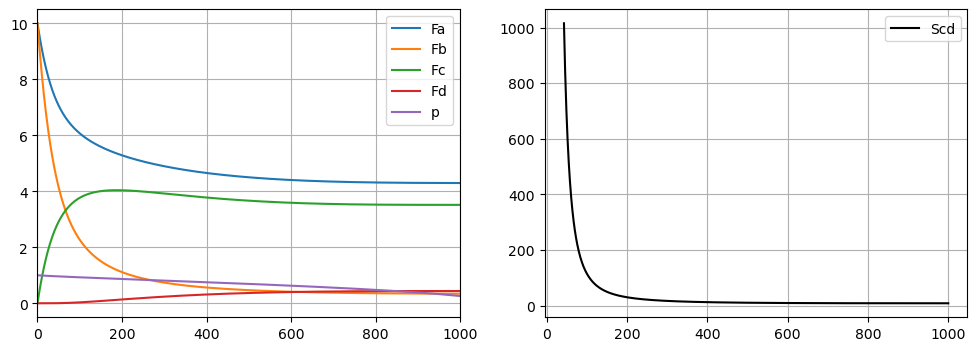

In [2]:
def simple_reaction(x, y, k):
    
    F = y[:4]
    p = y[4]
    
    C = Cto*(F/F.sum())*p
    
    # rate laws
    r1a = -k[0]*(C[0])*(C[1]**2)
    r2c = -k[1]*(C[0]**2)*(C[2]**3)
    
    # relative rates based on stoichiometry
    r2a = (2/3)*r2c
    r1b = 2*r1a
    r1c = -r1a
    r2d = (-1/3)*r2c
    
    # net rates
    ra = r1a + r2a
    rb = r1b
    rc = r1c + r2c
    rd = r2d
    
    return np.array([ra, rb, rc, rd])

def ode(x, y):
    
    F = y[:4]
    p = y[4]

    dF = simple_reaction(x, y, k)
    dy = -alpha*F.sum()/(Fto*2*p)
    
    if x > 0.0001:
        Scd = F[2]/F[3]
    else:
        Scd = 0
    
    return np.append(dF, dy)

alpha = 0.0019 # kg-1

k1a = 100 # (dm3/mol)^2/min/kgcat 
k2c = 1500 # dm15/mol4/ min/kgcat
k = [100, 1500]

v0 = 100 # dm3/min
Cto = 0.2 # mol/dm3
Fto = 20. # mol/min
Fa0 = 10. # mol/min 
Fb0 = 10. # mol/min

# initial conditions for the the dependent variables (4)
x0 = np.array([Fa0, Fb0, 0.0, 0.0, 1.0])

# declare a volume vector (volume window) for independent variable
W = np.linspace(0, 1000, 1000)

# solution of the ode
sol = solve_ivp(ode, [W[0], W[-1]], x0, t_eval = W)

Scd = sol.y[2,:]/sol.y[3,:]
print('The selectivity of Scd is {:.2f}'.format(Scd[-1]))

fig, ax = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

ax[0].plot(sol.t, sol.y[0,:], label = 'Fa')
ax[0].plot(sol.t, sol.y[1,:], label = 'Fb')
ax[0].plot(sol.t, sol.y[2,:], label = 'Fc')
ax[0].plot(sol.t, sol.y[3,:], label = 'Fd')
ax[0].plot(sol.t, sol.y[4,:], label = 'p')
ax[0].set_xlim(0, 1000)
ax[0].grid(linestyle='-')
ax[0].legend()

ax[1].plot(sol.t[43:], Scd[43:], 'k', label = 'Scd')
ax[1].grid(linestyle='-')
ax[1].legend()

***Multiple Gas Phase Reactions in a PBR - 2nd example***

\begin{equation*}4A + 5B → 4C + 6D \tag{1}\end{equation*}

\begin{equation*}2A + 1.5C → 3D + 1E \tag{2}\end{equation*}

\begin{equation*}1B + C → 2F \tag{3}\end{equation*}

\begin{equation*}4A + 6C → 6D + 5E \tag{4}\end{equation*}

where:

\begin{equation*}r_{1a} = -k_{1a}C_AC{_B^2} \tag{5}\end{equation*}

\begin{equation*}r_{2a} = -k_{2a}C_AC_B \tag{6}\end{equation*}

\begin{equation*}r_{3b} = -k_{3b}C_BC{_C^2} \tag{7}\end{equation*}

\begin{equation*}r_{4c} = -k_{4a}C_CC{_A^{2/3}} \tag{8}\end{equation*}

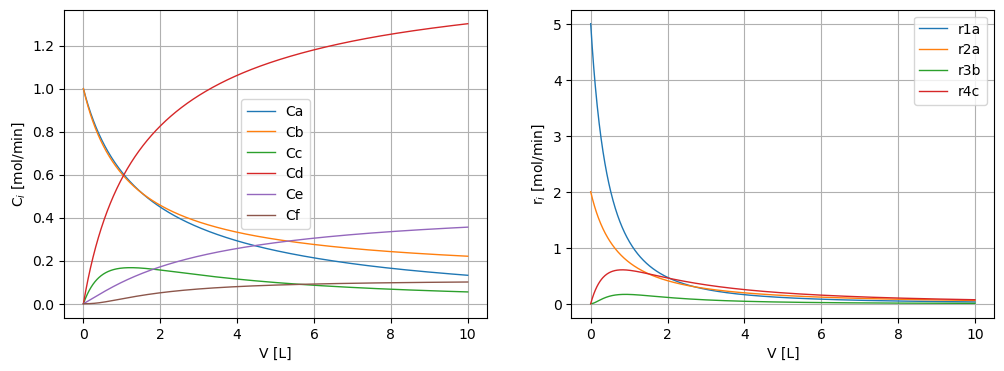

In [3]:
def simple_reaction(x, y, k):
    
    C = y
    
    # rate laws
    r1a = -k[0]*(C[0])*(C[1]**2)
    r2a = -k[1]*(C[0])*(C[1])
    r3b = -k[2]*(C[1])*(C[2]**2)
    r4c = -k[3]*(C[2])*(C[0]**(2/3))
       
    # net rates
    ra = r1a + r2a + (4/6)*r4c
    rb = (5/4)*r1a + (1.5/2)*r2a + r3b
    rc = -r1a + 2*r3b + r4c
    rd = -(6/4)*r1a - (3/2)*r2a - r4c
    re = -(1/2)*r2a - (5/6)*r4c
    rf = -2*r3b
    
    return np.array([ra, rb, rc, rd, re, rf])*(1/vol_flow)

def ode(x, y):
    
    return simple_reaction(x, y, k)

# k1a: (m3/kmol)^2/min, k2a: (m3/kmol/min), k3b: (m3/kmol)^2)/min, k4c: (m3/kmol)^2/3)/min
k = np.array([5.0, 2.0, 10.0, 5.0])

vol_flow = 10 # L/min

# mol/L
Ca0 = 1.0
Cb0 = 1.0

# initial conditions
x0 = [Ca0, Cb0, 0., 0., 0., 0.]

# declare a volume vector (volume window) for independent variable
V = np.linspace(0, 10, 1000)

# solution of the od
sol = solve_ivp(ode, [V[0], V[-1]], x0, t_eval = V)

Ca, Cb, Cc, Cd, Ce, Cf = sol.y

fig, ax = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

ax[0].plot(sol.t, Ca, label = 'Ca', lw = 1)
ax[0].plot(sol.t, Cb, label = 'Cb', lw = 1)
ax[0].plot(sol.t, Cc, label = 'Cc', lw = 1)
ax[0].plot(sol.t, Cd, label = 'Cd', lw = 1)
ax[0].plot(sol.t, Ce, label = 'Ce', lw = 1)
ax[0].plot(sol.t, Cf, label = 'Cf', lw = 1)
ax[0].set_ylabel('C$_i$ [mol/min]')
ax[0].set_xlabel('V [L]')
ax[0].legend(loc='best')
ax[0].legend()
ax[0].grid(linestyle='-')


r1a = k[0]*(Ca)*(Cb**2)
r2a = k[1]*(Ca)*(Cb)
r3b = k[2]*(Cb)*(Cc**2)
r4c = k[3]*(Cc)*(Ca**(2/3))


ax[1].plot(sol.t, r1a, label = 'r1a', lw = 1)
ax[1].plot(sol.t, r2a, label = 'r2a', lw = 1)
ax[1].plot(sol.t, r3b, label = 'r3b', lw = 1)
ax[1].plot(sol.t, r4c, label = 'r4c', lw = 1)
ax[1].legend(loc='best')
ax[1].grid(linestyle='dotted')
ax[1].set_ylabel('r$_i$ [mol/min]')
ax[1].set_xlabel('V [L]')
ax[1].legend(loc='best')
ax[1].grid(linestyle='-')